<a href="https://colab.research.google.com/github/anuga-community/anuga-clinic/blob/master/notebooks/notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANUGA Clinic

## Notebook 2: Merewether Flood Case Study

Here we look at a case study of a flood in the community of Merewether.  We will add a flow using an `Inlet_operator` and extract flow details at various points by interagating the `sww` file which is produced from each ANUGA run. 

This notebook is based on the the validation test [merewether](https://github.com/anuga-community/anuga_core/tree/master/validation_tests/case_studies/merewether), provided in the ANUGA distribution. 

## Setup Inline graphics and import anuga

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')
import anuga

## Read in Data

We have included some topography data and extent data in our `anuga-clinic-2018` download. 

Let's read that in and create a mesh associated with it. 

In [4]:
DATA_FOLDER = 'data_notebook2'

In [5]:
# Polygon defining broad area of interest
bounding_polygon = anuga.read_polygon(os.path.join(DATA_FOLDER,'extent.csv'))


# Polygon defining particular area of interest
merewether_polygon = anuga.read_polygon(os.path.join(DATA_FOLDER,'merewether.csv'))


# Elevation Data
topography_file = os.path.join(DATA_FOLDER,'topography1.asc')


# Resolution for most of the mesh
base_resolution = 80.0  # m^2

# Resolution in particular area of interest 
merewether_resolution = 25.0 # m^2

interior_regions = [[merewether_polygon, merewether_resolution]]

In [34]:
bounding_polygon

[[382255.0, 6354270.0],
 [382565.0, 6354270.0],
 [382565.0, 6354675.0],
 [382255.0, 6354675.0]]

## Create and View Domain


Note that we use a base_resolution to ensure a reasonable refinement overthe whole region, and we use interior_regions to refine the mesh in the area of interest. In this case we pass a list of polygon, resolution pairs. 

Figure files for each frame will be stored in _plot


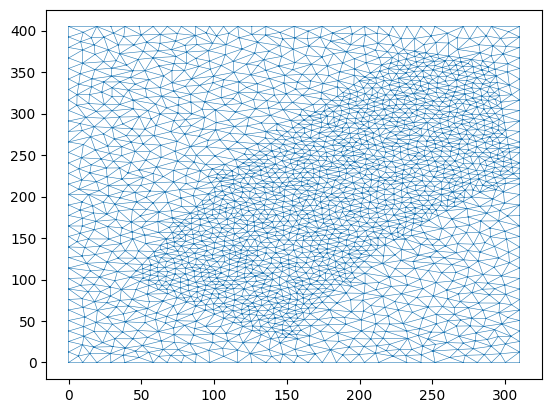

In [29]:
# JORGE: al parecer se cre un archivo del tipo .msh para la malla
domain = anuga.create_domain_from_regions(
            bounding_polygon,
            boundary_tags={'bottom': [0],
                           'right':  [1],
                           'top':    [2],
                           'left':   [3]},
            maximum_triangle_area=base_resolution,
            interior_regions=interior_regions)


domain.set_name('merewether1') # Name of sww file

# JORGE: se crea carpeta _plot/ para guardar las imagenes
dplotter = anuga.Domain_plotter(domain)  
plt.triplot(dplotter.triang, linewidth = 0.4)

## Setup Initial Conditions

We have to setup the values of various quantities associated with the domain. In particular we need to setup the `elevation` the elevation of the bed or the bathymetry. In this case we will do this using the DEM file `topography1.asc` .



Text(0.5, 1.0, 'Elevation')

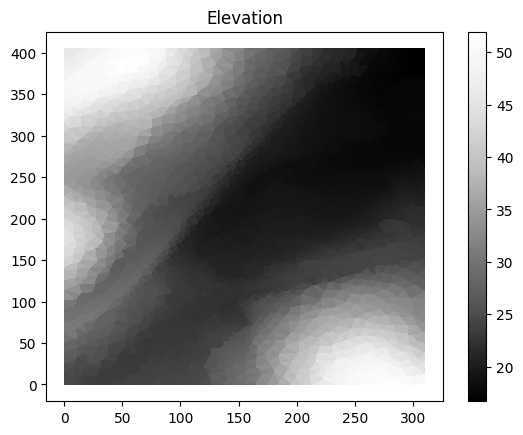

In [30]:
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', 0.025, location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 

plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar()
plt.title("Elevation")

## Setup Boundary Conditions

The rectangular domain has 4 tagged boundaries, left, top, right and bottom. We need to set boundary conditons for each of these tagged boundaries. We can set Transmissive type BC on the outflow boundaries and reflective on the others. 

In [31]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)

domain.set_boundary({'bottom':   Br,
                     'right':    Bt, # outflow
                     'top':      Bt, # outflow
                     'left':     Br})

## Setup Inflow 

We need some water to flow. The easiest way to input a specified amount of water is via an `Inlet_operator` where we can specify a discharge `Q`.

In [32]:
# Setup inlet flow
center = (382270.0, 6354285.0)
radius = 10.0
region0 = anuga.Region(domain, center=center, radius=radius)
fixed_inflow = anuga.Inlet_operator(domain, region0 , Q=0.7)

In [49]:
areas = domain.areas
indices = region0.indices
areas_region = areas[indices]
total_area = np.sum(areas_region)
print(total_area)

400.47104133506235


## Run the Evolution

We evolve using a `for` statement, which evolves the quantities using the shallow water wave solver. The calculation `yields` every `yieldstep` seconds, up to a given `duration`.

In [33]:
for t in domain.evolve(yieldstep=400, duration=2000):
  
    #dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0.0, vmax=1.0)
    
    domain.print_timestepping_statistics()

    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation() 

Time = 0.0000 (sec), steps=0 (22s)
Time = 400.0000 (sec), delta t = 1000.00000000 (s), steps=1 (0s)
Time = 800.0000 (sec), delta t in [0.43005028, 0.66728153] (s), steps=757 (1s)
Time = 1200.0000 (sec), delta t in [0.47190373, 0.53729375] (s), steps=818 (1s)
Time = 1600.0000 (sec), delta t in [0.47678998, 0.47779742] (s), steps=839 (1s)
Time = 2000.0000 (sec), delta t in [0.47656920, 0.47678981] (s), steps=840 (1s)


In [ ]:
anuga.barrier

## SWW File

The evolve loop saves the quantites at the end of each yield step to an `sww` file, with name domain name + extension sww. In this case the sww file is `merewether1.sww`. 

An sww file can be viewed via our 3D anuga-viewer application, via the crayfish plugin for QGIS, or simply read back into python using netcdf commands. 

For this clinic we have provided a wrapper called an SWW_plotter to provide easy acces to the saved quantities, stage, elev, depth, xmom, ymom, xvel, yvel, speed which are all time slices of centroid values, and a time variable.

In [ ]:
# Create a wrapper for contents of sww file
swwfile = 'merewether1.sww'
splotter = anuga.SWW_plotter(swwfile)


# Plot Depth and Speed at the last time slice
plt.subplot(121)
splotter.triang.set_mask(None)
plt.tripcolor(splotter.triang, 
              facecolors = splotter.depth[-1,:], 
              cmap='viridis')

plt.title("Depth")


plt.subplot(122)
splotter.triang.set_mask(None)
plt.tripcolor(splotter.triang, 
              facecolors = splotter.speed[-1,:], 
              cmap='viridis')

plt.title("Speed");


### Comparison

The data file ObservationPoints.csv contains some comparison depth data. Let's plot the depth for our simulation against the comparison data. 

In [ ]:
point_observations = np.genfromtxt(
    os.path.join(data_dir,'ObservationPoints.csv'),
    delimiter=",",skip_header=1)

# Convert to absolute corrdinates
xc = splotter.xc + splotter.xllcorner
yc = splotter.yc + splotter.yllcorner

nearest_points = []
for row in point_observations:
    nearest_points.append(np.argmin( (xc-row[0])**2 + (yc-row[1])**2 ))
 
loc_id = point_observations[:,2]

fig, ax = plt.subplots()
ax.plot(loc_id, point_observations[:,4], 'or', label='ARR')
ax.plot(loc_id, point_observations[:,5], 'xb', label='Tuflow')
ax.plot(loc_id, splotter.stage[-1,nearest_points], '*g', label='Anuga')

plt.xticks(range(0,5))
plt.xlabel('ID')
plt.ylabel('Stage')
ax.legend()

plt.show()


## Flow with Houses

We have polygonal data which specifies the location of a number of structures (homes) in our study. We can consider the flow in which those houses are cut out of the simulation. 

First we read in the house polygonal data. To maintain a small mesh size we will only read in structures with an area grester than 60 m^2. 

In [ ]:
# Read in house polygons from data directory and retain those of area > 60 m^2

import glob
house_files = glob.glob(os.path.join(data_dir,'house*.csv'))

house_polygons = []
for hf in house_files:
  house_poly = anuga.read_polygon(hf)
  poly_area = anuga.polygon_area(house_poly)
  
  # Leave out some small houses
  if poly_area > 60:
    house_polygons.append(house_poly)

### Create Domain 

To incorporate the housing information, we will cutout the polygons representing the houses. This is done by passing the list of house polygons to the `interior_holes` argument of the `anuga.create_domain_from_regions` procedure. 

This will produce a new tagged boundary region called `interior`. We will have to assign a boundsry condition to this new boundary region.

In [ ]:
# Resolution for most of the mesh
base_resolution = 20.0  # m^2

# Resolution in particular area of interest 
merewether_resolution = 10.0 # m^2

domain = anuga.create_domain_from_regions(
            bounding_polygon,
            boundary_tags={'bottom': [0],
                           'right':  [1],
                           'top':    [2],
                           'left':   [3]},
            maximum_triangle_area=base_resolution,
            interior_holes=house_polygons,
            interior_regions=interior_regions)


domain.set_name('merewether2') # Name of sww file
domain.set_low_froude(1)

# Setup Initial Conditions
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', 0.01, location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 

# Setup BC
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)


# NOTE: We need to assign a BC to the interior boundary region.
domain.set_boundary({'bottom':   Br,
                     'right':    Bt, # outflow
                     'top':      Bt, # outflow
                     'left':     Br,
                     'interior': Br})


# Setup inlet flow
center = (382270.0, 6354285.0)
radius = 10.0
region0 = anuga.Region(domain, center=center, radius=radius)
fixed_inflow = anuga.Inlet_operator(domain, region0 , Q=19.7)


dplotter = anuga.Domain_plotter(domain)  
plt.triplot(dplotter.triang, linewidth = 0.4);

### Evolve

In [ ]:
for t in domain.evolve(yieldstep=20, duration=300):
  
    #dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0.0, vmax=1.0)
    
    domain.print_timestepping_statistics()

    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation() 

### Read in SWW File and Compare

Perhaps not conclusive, but with the houses the `anuga` results, especially for id point 0, are much closer to the comparison  results. Note that we are running with a very coarse mesh for this case study. 

In [ ]:
# Create a wrapper for contents of sww file
swwfile2 = 'merewether2.sww'
splotter2 = anuga.SWW_plotter(swwfile2)

# Convert to absolute corrdinates
xc = splotter2.xc + splotter2.xllcorner
yc = splotter2.yc + splotter2.yllcorner

nearest_points_2 = []
for row in point_observations:
    nearest_points_2.append(np.argmin( (xc-row[0])**2 + (yc-row[1])**2 ))
 
loc_id = point_observations[:,2]

fig, ax = plt.subplots()
ax.plot(loc_id, point_observations[:,4], 'or', label='ARR')
ax.plot(loc_id, point_observations[:,5], 'xb', label='Tuflow')
ax.plot(loc_id, splotter2.stage[-1,nearest_points_2], '+k', label='Anuga1')
ax.plot(loc_id, splotter.stage[-1,nearest_points], '*g', label='Anuga0')


plt.xticks(range(0,5))
plt.xlabel('ID')
plt.ylabel('Stage')
ax.legend()

plt.show()

[Next Notebook](https://colab.research.google.com/github/anuga-community/anuga-clinic/blob/master/notebooks/notebook3.ipynb)